# AUEB M.Sc. in Data Science (part-time)

**Course**: Text Analytics

**Semester**: Spring 2018

**4th homework**: Sentiment analysis on a Twitter dataset of a large number of tweets, using RNNs with Keras (using ELMo).

**Team members**:

- Alexandros Kaplanis (https://github.com/AlexcapFF/)
- Spiros Politis
- Manos Proimakis (https://github.com/manosprom)

---

## Homework

Repeat Exercise 10 of Part 3 (text classification with MLPs), now using a bi-directional stacked RNN (with GRU or LSTM cells) and a self-attention MLP , all implemented (by you) in Keras, TensorFlow, PyTorch, or DyNet. Tune the hyper-parameters (e.g. number of stacked RNNs, number of hidden layers in the self-attention MLP) on a held-out part of the training data or using a cross-validation on the training data. You may optionally add an extra RNN layer to produce word embeddings from characters, concatenating each resulting character-based word embedding with the corresponding pre-trained (e.g. via Word2Vec) word embedding. You may optionally add a pre-trained language model (e.g., ELMo) as an extra layer to obtain context-sensitive word embeddings.

---

## Required packages and classes

In [1]:
import sys
import os
import itertools
import collections 
import pickle

import numpy as np

import sklearn.model_selection
import sklearn

import keras.preprocessing.text
import keras.preprocessing.sequence
import keras.callbacks
import keras.optimizers

import keras_tqdm

import matplotlib.pyplot as plt

# Import required classes, implemented for the assignment.
sys.path.append('src')

import utilities, preprocessing
from RNN import RNN

%matplotlib inline

Using TensorFlow backend.


## Data ingestion

In [2]:
original_training_df = utilities.create_dataset(
    'data/training.1600000.processed.noemoticon.csv', 
    sys.maxsize
)

original_test_df = utilities.create_dataset(
    'data/testdata.manual.2009.06.14.csv', 
    sys.maxsize
)

### Inspection of our training set

In [3]:
display(original_training_df.head(10))

print("Size: ", len(original_training_df))

,polarity,date,query,user,text
id,,,,,
1467810369,0,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1467810672,0,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
1467810917,0,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
1467811184,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
1467811193,0,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
1467811372,0,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
1467811592,0,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
1467811594,0,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,"@LOLTrish hey long time no see! Yes.. Rains a bit ,only a bit LOL , I'm fine thanks , how's you ?"
1467811795,0,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it


Size:  1600000


### Inspection of our test set

In [4]:
display(original_test_df.head(10))

print("Size: ", len(original_test_df))

,polarity,date,query,user,text
id,,,,,
9,0,Mon May 11 03:22:30 UTC 2009,aig,Seth937,Fuck this economy. I hate aig and their non loan given asses.
14,0,Mon May 11 03:32:48 UTC 2009,obama,kylesellers,"@Karoli I firmly believe that Obama/Pelosi have ZERO desire to be civil. It's a charade and a slogan, but they want to destroy conservatism"
17,0,Mon May 11 05:06:22 UTC 2009,nike,vincentx24x,"dear nike, stop with the flywire. that shit is a waste of science. and ugly. love, @vincentx24x"
19,0,Mon May 11 05:20:28 UTC 2009,lebron,luv8242,I was talking to this guy last night and he was telling me that he is a die hard Spurs fan. He also told me that he hates LeBron James.
21,0,Mon May 11 05:21:37 UTC 2009,lebron,ursecretdezire,"@ludajuice Lebron is a Beast, but I'm still cheering 4 the A..til the end."
119,0,Sat May 16 16:19:24 UTC 2009,google,vamsmack,Played with an android google phone. The slide out screen scares me I would break that fucker so fast. Still prefer my iPhone.
120,0,Sat May 16 16:25:41 UTC 2009,aig,schroncd,US planning to resume the military tribunals at Guantanamo Bay... only this time those on trial will be AIG execs and Chrysler debt holders
121,0,Sat May 16 22:42:07 UTC 2009,itchy,MarissaLeeD,omg so bored &amp; my tattoooos are so itchy!! help! aha =)
122,0,Sat May 16 22:42:25 UTC 2009,itchy,robloposky,I'm itchy and miserable!


Size:  359


how are the categories of tweets distrubuted between positive and negative

Text(0.5,1,'Dataset labels distribuition')

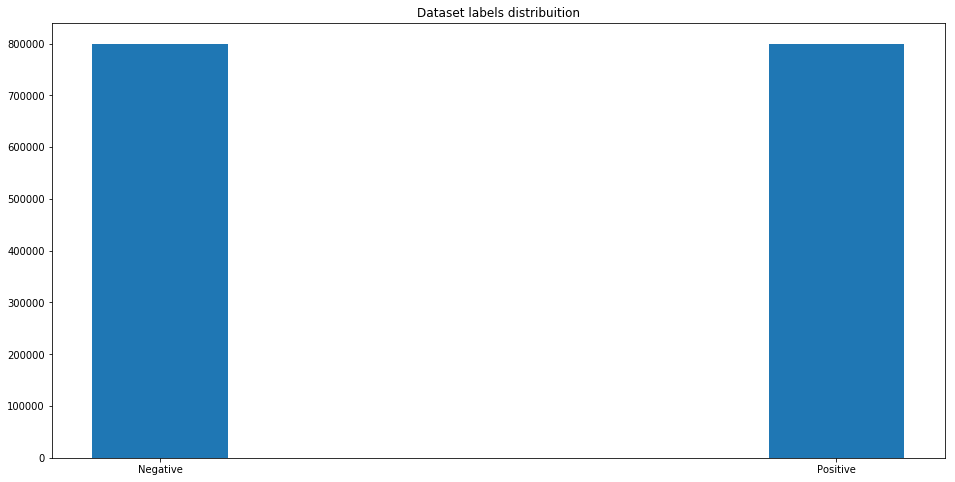

In [5]:
target_cnt = collections.Counter(original_training_df['polarity'])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.xticks([0, 4], ['Negative', 'Positive'])
plt.title("Dataset labels distribuition")

## Sampling

In order to ensure that our train / dev/ test / heldout sets follow the same probability distribution, since the dataset contains many samples and because half of them is Negative(0) and the other half is Positive(4) we cannot just take N random number of rows from the whole dataset and we need to distribute it beside the positive and negative samples which will be done as below.

The dataset contains thes same size of rows for Negative and Positive tweets, here we will keep a balanced set of 50000 positive and 50000 negative tweets taken randomly.

In [6]:
training_df = utilities.take_n_samples_from_each_category(original_training_df, 50000)

## Preprocessing

In [7]:
df = training_df.copy()
df['text_before_preprocess'] = df['text']
df.drop(columns=['date', 'query'], axis=1, inplace=True)
df['length_before_preprocess'] = df['text_before_preprocess'].str.len()
df.reset_index(drop=True, inplace=True)

In [8]:
df['text']= df['text'].apply(lambda row: preprocessing.preprocess_row(row))
df['length'] = df['text'].str.len()

### Keep only relevant data
We keep only the list of texts to create the embeddings
and the list of the polarity per tweet as target

In [9]:
corpus = df['text'].values.tolist()
target = df['polarity'].values.tolist()

In [10]:
df = df.drop_duplicates(subset=['user','text'], keep = 'first')

In [11]:
df.drop(columns=['user'], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

## Train / Heldout / Dev sets

- Τraining set: will be used for the training of our MLP
- Heldout set: will be used for hyperparameter tuning
- Development (validation) set: will be used to monitor the performance of our MLP during training and optimization process

We have employed the established 50/25/25 rule.

In [12]:
X_train, X_heldout_dev, y_train, y_heldout_dev = sklearn.model_selection.train_test_split(
    corpus, 
    target, 
    test_size = 0.25, 
    shuffle = True
)

X_heldout, X_dev, y_heldout, y_dev = sklearn.model_selection.train_test_split(
    X_heldout_dev, 
    y_heldout_dev, 
    test_size = 0.5, 
    shuffle = True
)

In [13]:
print('Size of X_train: ', len(X_train))
print('Size of X_heldout: ', len(X_heldout))
print('Size of X_dev: ', len(X_dev))
print('Size of y_train: ', len(y_train))
print('Size of y_heldout: ', len(y_heldout))
print('Size of y_dev: ', len(y_dev))

Size of X_train:  75000
Size of X_heldout:  12500
Size of X_dev:  12500
Size of y_train:  75000
Size of y_heldout:  12500
Size of y_dev:  12500


In [14]:
df_test = original_test_df.copy()
df_test.drop(columns=['date', 'query', 'user'], axis=1, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_test['text']= df_test['text'].apply(lambda row: preprocessing.preprocess_row(row))
X_test = df_test['text'].values.tolist()
y_test = df_test['polarity'].values.tolist()

In [15]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_dev)
y_dev = le.transform(y_dev)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_heldout)
y_heldout = le.transform(y_heldout)

le = sklearn.preprocessing.LabelEncoder()
le.fit(y_test)
y_test = le.transform(y_test)

## Baseline model experiments

In [16]:
def checkpoint(name):
    return keras.callbacks.ModelCheckpoint(
        name, 
        monitor = 'val_f1', 
        verbose = 1, 
        save_best_only = True, 
        mode = 'max'
    )

early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    verbose = 1 
)

## Elmo

In [17]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
import numpy as np

from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

# Initialize session
sess = tf.Session()
K.set_session(sess)

DENSE_NUM_NEURONS = 100
N_CLASSES = 1

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

input_text = layers.Input(shape=(1,), dtype="string")
embedding = ElmoEmbeddingLayer()(input_text)
dropout = Dropout(rate=0.2)(embedding)
dense = layers.Dense(DENSE_NUM_NEURONS, activation='relu')(dropout)
pred = layers.Dense(N_CLASSES, activation='sigmoid')(dense)

elmo_model = Model(inputs=[input_text], outputs=pred)
elmo_model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(lr = 0.001), 
    metrics=[utilities.precision, utilities.recall, utilities.f1, utilities.accuracy])

W0716 21:14:34.454478 140586483119936 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 21:14:34.458448 140586483119936 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 21:14:35.684434 140586483119936 deprecation_wrapper.py:119] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0716 21:14:35.692477 140586483119936 deprecation.py:506] From /home/manos/.conda/envs/ta_assignment4/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445:

Training with elmo is pretty slow since we have used batches of 50 tweets. We had to do that since the elmob embeddings has 1024 size and we get many OOM expcetions using GPU.

In [18]:


X_train_1 = np.array(X_train, dtype=object)[:, np.newaxis]
X_heldout_1 = np.array(X_heldout, dtype=object)[:, np.newaxis]

elmo_model.fit(
    X_train_1, 
    y_train,
    validation_data=(X_heldout_1, y_heldout),
    batch_size = 50,
    epochs = 50,
    verbose = 2,
    callbacks = [checkpoint('models/elmo'), early_stopping, keras_tqdm.TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    shuffle = True
)

Train on 75000 samples, validate on 12500 samples


Epoch 1/50


 - 420s - loss: 0.5260 - precision: 0.7426 - recall: 0.7314 - f1: 0.7287 - accuracy: 0.7353 - val_loss: 0.5079 - val_precision: 0.7860 - val_recall: 0.6923 - val_f1: 0.7318 - val_accuracy: 0.7541

Epoch 00001: val_f1 improved from -inf to 0.73181, saving model to models/elmo
Epoch 2/50


 - 409s - loss: 0.4942 - precision: 0.7626 - recall: 0.7518 - f1: 0.7519 - accuracy: 0.7572 - val_loss: 0.4934 - val_precision: 0.7345 - val_recall: 0.8178 - val_f1: 0.7707 - val_accuracy: 0.7634

Epoch 00002: val_f1 improved from 0.73181 to 0.77067, saving model to models/elmo
Epoch 3/50


 - 413s - loss: 0.4777 - precision: 0.7741 - recall: 0.7616 - f1: 0.7630 - accuracy: 0.7685 - val_loss: 0.4817 - val_precision: 0.7562 - val_recall: 0.7874 - val_f1: 0.7682 - val_accuracy: 0.7688

Epoch 00003: val_f1 did not improve from 0.77067
Epoch 4/50


 - 412s - loss: 0.4655 - precision: 0.7814 - recall: 0.7719 - f1: 0.7718 - accuracy: 0.7766 - val_loss: 0.4866 - val_precision: 0.8108 - val_recall: 0.6887 - val_f1: 0.7401 - val_accuracy: 0.7664

Epoch 00004: val_f1 did not improve from 0.77067
Epoch 5/50


 - 425s - loss: 0.4540 - precision: 0.7895 - recall: 0.7798 - f1: 0.7805 - accuracy: 0.7849 - val_loss: 0.4729 - val_precision: 0.7850 - val_recall: 0.7565 - val_f1: 0.7667 - val_accuracy: 0.7769

Epoch 00005: val_f1 did not improve from 0.77067
Epoch 6/50


 - 441s - loss: 0.4458 - precision: 0.7952 - recall: 0.7843 - f1: 0.7854 - accuracy: 0.7902 - val_loss: 0.4803 - val_precision: 0.7421 - val_recall: 0.8250 - val_f1: 0.7778 - val_accuracy: 0.7710

Epoch 00006: val_f1 improved from 0.77067 to 0.77782, saving model to models/elmo
Epoch 7/50


 - 464s - loss: 0.4355 - precision: 0.7990 - recall: 0.7902 - f1: 0.7905 - accuracy: 0.7950 - val_loss: 0.4746 - val_precision: 0.7622 - val_recall: 0.7897 - val_f1: 0.7721 - val_accuracy: 0.7738

Epoch 00007: val_f1 did not improve from 0.77782
Epoch 8/50


 - 465s - loss: 0.4254 - precision: 0.8049 - recall: 0.7968 - f1: 0.7968 - accuracy: 0.8011 - val_loss: 0.4800 - val_precision: 0.7472 - val_recall: 0.8063 - val_f1: 0.7723 - val_accuracy: 0.7686

Epoch 00008: val_f1 did not improve from 0.77782
Epoch 9/50


 - 456s - loss: 0.4164 - precision: 0.8117 - recall: 0.8026 - f1: 0.8032 - accuracy: 0.8073 - val_loss: 0.4771 - val_precision: 0.7821 - val_recall: 0.7547 - val_f1: 0.7642 - val_accuracy: 0.7745

Epoch 00009: val_f1 did not improve from 0.77782
Epoch 10/50


 - 423s - loss: 0.4049 - precision: 0.8184 - recall: 0.8083 - f1: 0.8095 - accuracy: 0.8136 - val_loss: 0.4852 - val_precision: 0.7486 - val_recall: 0.8190 - val_f1: 0.7790 - val_accuracy: 0.7740

Epoch 00010: val_f1 improved from 0.77782 to 0.77902, saving model to models/elmo
Epoch 00010: early stopping



In [20]:
X_dev_1 = np.array(X_dev, dtype=object)[:, np.newaxis]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 102,605
Trainable params: 102,605
Non-trainable params: 0
_________________________________________________________________
None
12500/12500 [==============================] - 64s 5ms/step

Test binary cross entropy: 0.4629

Test precision: 0.7640

Test recall

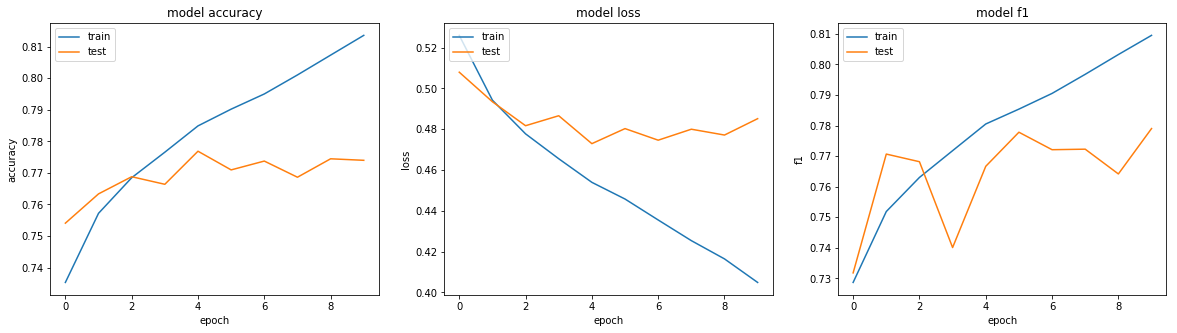

In [21]:
print(elmo_model.summary())

utilities.plot_history(elmo_model.history)

utilities.print_evaluation(elmo_model, X_dev_1, y_dev)

---